<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/TransformerAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# One-cell: Transformer forecast AD + clear bands & forecast line
 - 日本語コメント / 図は英語
 - 上段: オレンジ=signal, 紫破線=forecast, 青/赤/緑の縦帯=GT/Detected/Overlap
 - 下段: GT/Detected/Overlap の3段マスク + score と閾値



In [19]:
import numpy as np
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# ---- 乱数・デバイス ----
np.random.seed(7); torch.manual_seed(7)
torch.set_num_threads(1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [20]:
# -----------------------------
# 1) データ生成：正常 + テスト区間に異常注入
# -----------------------------
N = 3000
t = np.arange(N)
# 正常波形（周期2種 + ノイズ）
signal = 0.9*np.sin(2*np.pi*t/60) + 0.35*np.sin(2*np.pi*t/15) + 0.2*np.random.randn(N)

# ground-truth 異常マスク
gt = np.zeros(N, dtype=bool)
# スパイク
signal[2200] += 2.7; gt[2200] = True
signal[2300] -= 2.9; gt[2300] = True
for idx in [2210, 2220, 2232]:
    signal[idx] += 1.1 + 0.2*np.random.randn(); gt[idx] = True
# 高周波セグメント
seg_start, seg_end = 2350, 2410
seg_t = np.arange(seg_end - seg_start)
signal[seg_start:seg_end] += 0.9*np.sin(2*np.pi*seg_t/6) + 0.25*np.random.randn(seg_end - seg_start)
gt[seg_start:seg_end] = True
# レベルシフト
shift_start, shift_end = 2665, 2745
signal[shift_start:shift_end] += np.linspace(0.0, 2.2, shift_end - shift_start) + 0.15*np.random.randn(shift_end - shift_start)
gt[shift_start:shift_end] = True


In [21]:
# -----------------------------
# 2) 1-step 予測データセット（過去L→現在）
# -----------------------------
L = 64  # 入力長
def make_supervised_1step(x, L):
    X, Y = [], []
    for i in range(L, len(x)):
        X.append(x[i-L:i]); Y.append(x[i])
    return np.array(X, np.float32)[:, :, None], np.array(Y, np.float32)[:, None]

X_all, Y_all = make_supervised_1step(signal, L)   # 対応時刻は L..N-1
times = np.arange(L, N)

# 区間分割：Train(0..1799), Val(1800..1999), Test(2000..2999)
def idx_mask(times, lo, hi): return (times >= lo) & (times < hi)
mask_tr = idx_mask(times, 0, 1800)
mask_va = idx_mask(times, 1800, 2000)
mask_te = idx_mask(times, 2000, 3000)

Xtr, Ytr = X_all[mask_tr], Y_all[mask_tr]
Xva, Yva = X_all[mask_va], Y_all[mask_va]
Xte, Yte = X_all[mask_te], Y_all[mask_te]
t_tr, t_va, t_te = times[mask_tr], times[mask_va], times[mask_te]

In [22]:
# -----------------------------
# 3) Transformer（因果マスク）で1-step予測
# -----------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=4096):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(pos*div); pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x): return x + self.pe[:, :x.size(1), :]

class TransformerOneStep(nn.Module):
    # 入力[B,L,1] → d_model → TransformerEncoder（過去のみ）→ 最終トークンからスカラー
    def __init__(self, L, d_model=48, nhead=4, layers=2, dim_ff=96, dropout=0.1):
        super().__init__()
        self.L = L
        self.inp = nn.Linear(1, d_model)
        self.pos = PositionalEncoding(d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_ff, dropout, batch_first=True)
        self.enc = nn.TransformerEncoder(enc_layer, num_layers=layers)
        self.head = nn.Linear(d_model, 1)
    def forward(self, x):
        h = self.pos(self.inp(x))
        mask = torch.triu(torch.ones(self.L, self.L, device=x.device), diagonal=1).bool()
        h = self.enc(h, mask=mask)
        return self.head(h[:, -1, :])  # [B,1]

model = TransformerOneStep(L=L).to(device)

In [23]:
# -----------------------------
# 4) 学習（正常のみ）
# -----------------------------
def to_tensor(x): return torch.from_numpy(x).to(device)
Xtr_t, Ytr_t = to_tensor(Xtr), to_tensor(Ytr)
Xva_t, Yva_t = to_tensor(Xva), to_tensor(Yva)
Xte_t, Yte_t = to_tensor(Xte), to_tensor(Yte)

crit = nn.MSELoss(); opt = optim.Adam(model.parameters(), lr=2e-3)
def batched_iter(X, Y, bs=512):
    for s in range(0, len(X), bs): yield X[s:s+bs], Y[s:s+bs]

epochs = 3  # CPUでも速い設定
for ep in range(1, epochs+1):
    model.train(); tr=0
    for xb, yb in batched_iter(Xtr_t, Ytr_t, bs=512):
        opt.zero_grad(); loss = crit(model(xb), yb); loss.backward(); opt.step(); tr += loss.item()
    model.eval()
    with torch.no_grad():
        va = sum(crit(model(xb), yb).item() for xb, yb in batched_iter(Xva_t, Yva_t, bs=1024))
    print(f"epoch {ep}/{epochs}  train={tr/(len(Xtr)//512+1):.5f}  val={va/(len(Xva)//1024+1):.5f}")


epoch 1/3  train=0.57175  val=0.12844
epoch 2/3  train=0.16051  val=0.10645
epoch 3/3  train=0.13976  val=0.09735


In [24]:
# -----------------------------
# 5) 予測・スコア（robust Z + EWMA）・ヒステリシス
# -----------------------------
with torch.no_grad():
    yhat_va = model(Xva_t).cpu().numpy().squeeze(-1)
    yhat_te = model(Xte_t).cpu().numpy().squeeze(-1)
res_val = (Yva.squeeze(-1) - yhat_va)
res_te  = (Yte.squeeze(-1) - yhat_te)

# robust Z（検証の中央値＆MADで標準化）
def robust_z(res_val, res_x):
    med = np.median(res_val); mad = np.median(np.abs(res_val - med)) + 1e-8
    return np.abs((res_x - med) / (1.4826*mad))

z_val = robust_z(res_val, res_val)
z_te  = robust_z(res_val, res_te)

# EWMA 平滑
beta = 0.25
val_s = np.zeros_like(z_val); val_s[0] = z_val[0]
for i in range(1, len(z_val)): val_s[i] = beta*z_val[i] + (1-beta)*val_s[i-1]
score = np.zeros_like(z_te); score[0] = z_te[0]
for i in range(1, len(z_te)): score[i] = beta*z_te[i] + (1-beta)*score[i-1]

# ヒステリシス閾値（enter > exit）
thr_enter = np.quantile(val_s, 0.995)
thr_exit  = np.quantile(val_s, 0.97)

# persistence（最小連続長）
k_enter = 3
det_local = np.zeros_like(score, dtype=bool)
state=False; run=0; start=0
for i, s in enumerate(score):
    if not state:
        if s > thr_enter:
            run += 1
            if run == 1: start = i
            if run >= k_enter: state=True; det_local[start:i+1]=True
        else:
            run = 0
    else:
        det_local[i] = True
        if s < thr_exit: state=False; run=0

# テスト領域ローカル検知を全体時刻へ
det_mask = np.zeros(N, dtype=bool)
det_mask[t_te] = det_local

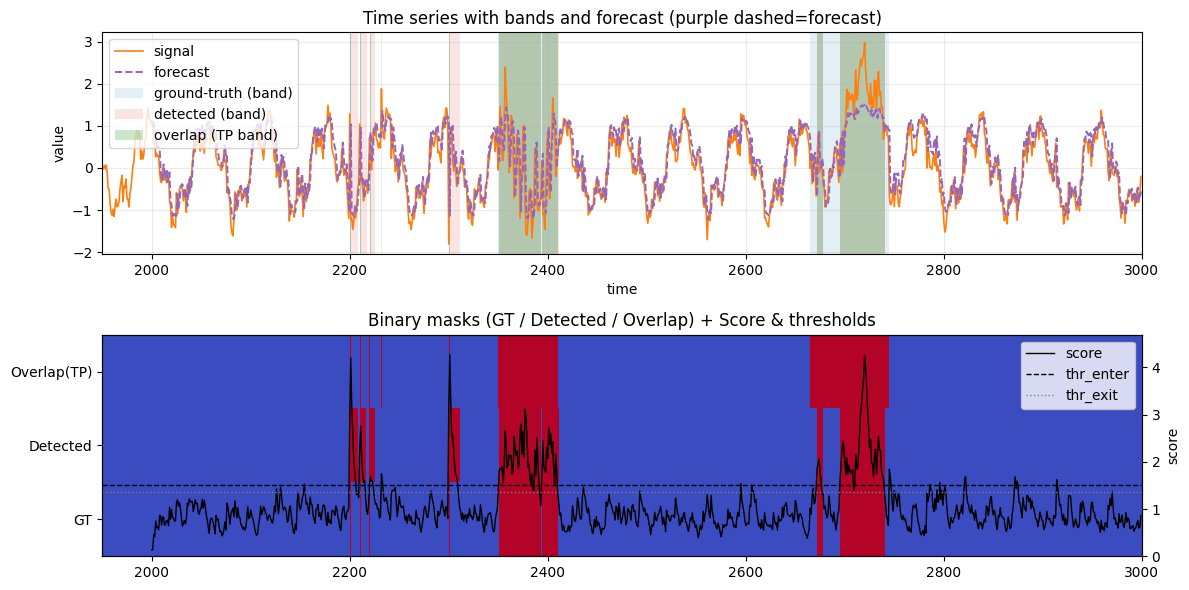

In [25]:
# -----------------------------
# 6) 可視化（予測線=紫破線、縦帯でGT/Detected/Overlap）
# -----------------------------
lo, hi = 1950, 3000  # 表示範囲

def draw_spans(ax, mask, color, alpha=0.18):
    # Trueの連続区間を縦帯で塗る
    i = lo
    while i < hi:
        if mask[i]:
            j = i + 1
            while j < hi and mask[j]: j += 1
            ax.axvspan(i, j, color=color, alpha=alpha, linewidth=0)
            i = j
        else:
            i += 1

plt.figure(figsize=(12, 6))

# (上) signal + forecast + bands
ax1 = plt.subplot(2,1,1)
line_signal, = ax1.plot(t[lo:hi], signal[lo:hi], color="tab:orange", lw=1.2, label="signal")
mask_plot_forecast = (t_te >= lo) & (t_te < hi)
line_forecast, = ax1.plot(t_te[mask_plot_forecast], yhat_te[mask_plot_forecast],
                          linestyle='--', color='tab:purple', lw=1.4, label='forecast')

gt_band   = gt.copy()
det_band  = det_mask.copy()
over_band = gt_band & det_band
draw_spans(ax1, gt_band,   color='tab:blue',  alpha=0.12)
draw_spans(ax1, det_band,  color='tab:red',   alpha=0.12)
draw_spans(ax1, over_band, color='tab:green', alpha=0.25)

# 凡例（帯の説明をPatchで追加）
handles = [
    line_signal,
    line_forecast,
    Patch(facecolor='tab:blue',  alpha=0.12, label='ground-truth (band)'),
    Patch(facecolor='tab:red',   alpha=0.12, label='detected (band)'),
    Patch(facecolor='tab:green', alpha=0.25, label='overlap (TP band)'),
]
ax1.legend(handles=handles, loc="upper left")
ax1.set_title("Time series with bands and forecast (purple dashed=forecast)")
ax1.set_xlabel("time"); ax1.set_ylabel("value"); ax1.grid(True, alpha=0.25)

# (下) Binary masks + Score & thresholds
ax2 = plt.subplot(2,1,2, sharex=ax1)
band = np.vstack([gt[lo:hi].astype(int), det_mask[lo:hi].astype(int), (gt & det_mask)[lo:hi].astype(int)])
ax2.imshow(band, aspect='auto', interpolation='nearest', extent=[lo, hi, 0, 3], cmap='coolwarm', vmin=0, vmax=1)
ax2.set_yticks([0.5, 1.5, 2.5]); ax2.set_yticklabels(["GT", "Detected", "Overlap(TP)"])
ax2.set_title("Binary masks (GT / Detected / Overlap) + Score & thresholds")

ax3 = ax2.twinx()
ax3.plot(t_te, score, color='k', lw=1.0, label='score')
ax3.axhline(thr_enter, color='k', ls='--', lw=1.0, label='thr_enter')
ax3.axhline(thr_exit,  color='gray', ls=':',  lw=1.0, label='thr_exit')
ax3.set_ylim(0, max(score.max(), thr_enter)*1.1)
ax3.set_ylabel("score")
ax3.legend(loc="upper right")

plt.tight_layout(); plt.show()
